# Kaggle Competition - Quant & Machine Learning Course
# Tutorial 8: Xgboost &  Light GBM
- modified based on https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/
- algorithm overview https://www.kaggle.com/prashant111/lightgbm-classifier-in-python

In [1]:
# https://github.com/scikit-learn/scikit-learn/issues/12939#issuecomment-512057853
import os
os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [2]:
#importing standard libraries 
import numpy as np 
import pandas as pd 
from pandas import Series, DataFrame 

In [3]:
#import lightgbm and xgboost 
import lightgbm as lgb 
import xgboost as xgb 

#loading our training dataset 'adult.csv' with name 'data' using pandas 
data=pd.read_csv('~/Documents/deep-learning/quant_course/data/adult.csv') 

# Adult dataset
detailed data description https://cseweb.ucsd.edu//classes/sp15/cse190-c/reports/sp15/048.pdf

In [4]:
data.sample(5).T
#fnlwgt: final weight. In other words, this is the number of people the census believes

,5695,13319,26154,620,1997
age,4,1,4,0,4
workclass,Private,Private,Private,Private,Self-emp-not-inc
fnlwgt,339473,221215,148874,190483,30599
education,Some-college,10th,9th,Bachelors,Masters
education-num,10,6,5,13,14
marital-status,Divorced,Never-married,Married-civ-spouse,Never-married,Married-spouse-absent
occupation,Sales,Handlers-cleaners,Craft-repair,Sales,Prof-specialty
relationship,Not-in-family,Other-relative,Husband,Own-child,Not-in-family
race,White,White,Black,White,White
sex,Female,Male,Male,Female,Female


In [5]:
#Assigning names to the columns 
data.columns=['age','workclass','fnlwgt','education','education-num','marital_Status','occupation','relationship','race','sex','capital_gain','capital_loss','hours_per_week','native_country','Income'] 

#glimpse of the dataset 
data.head() 

# Label Encoding our target variable 
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
l=LabelEncoder() 
l.fit(data.Income) 

l.classes_ 
data.Income=Series(l.transform(data.Income))  #label encoding our target variable 
data.Income.value_counts() 

 

#One Hot Encoding of the Categorical features 
one_hot_workclass=pd.get_dummies(data.workclass) 
one_hot_education=pd.get_dummies(data.education) 
one_hot_marital_Status=pd.get_dummies(data.marital_Status) 
one_hot_occupation=pd.get_dummies(data.occupation)
one_hot_relationship=pd.get_dummies(data.relationship) 
one_hot_race=pd.get_dummies(data.race) 
one_hot_sex=pd.get_dummies(data.sex) 
one_hot_native_country=pd.get_dummies(data.native_country) 

#removing categorical features 
data.drop(['workclass','education','marital_Status','occupation','relationship','race','sex','native_country'],axis=1,inplace=True) 

 

#Merging one hot encoded features with our dataset 'data' 
data=pd.concat([data,one_hot_workclass,one_hot_education,one_hot_marital_Status,one_hot_occupation,one_hot_relationship,one_hot_race,one_hot_sex,one_hot_native_country],axis=1) 

#removing dulpicate columns 
_, i = np.unique(data.columns, return_index=True) 
data=data.iloc[:, i] 

#Here our target variable is 'Income' with values as 1 or 0.  
#Separating our data into features dataset x and our target dataset y 
x=data.drop('Income',axis=1) 
y=data.Income 

 

#Imputing missing values in our target variable 
y.fillna(y.mode()[0],inplace=True) 

#Now splitting our dataset into test and train 
from sklearn.model_selection import train_test_split 
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.3)

In [6]:
data.head()

,10th,11th,12th,1st-4th,5th-6th,7th-8th,9th,Adm-clerical,Amer-Indian-Eskimo,Armed-Forces,...,Widowed,Wife,Without-pay,Yugoslavia,age,capital_gain,capital_loss,education-num,fnlwgt,hours_per_week
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,2,1,0,13,77516,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,3,0,0,13,83311,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,9,215646,2
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,3,0,0,7,234721,2
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,13,338409,2


# Xgboost
- method 1: sklearn API
    - model.fit
    - dataset input compatible with pandas or numpy
    - can direclty use sklean cv, gridsearchcv etc.

In [7]:
# method 1: sklearn API
model = xgb.XGBClassifier(eval_metric="logloss", use_label_encoder=False, verbosity=0)
model.fit(x_train, y_train)
ypred = model.predict(x_test)
#Converting probabilities into 1 or 0  
for i in range(0,len(ypred)): 
    if ypred[i]>=.5:       # setting threshold to .5 
        ypred[i]=1 
    else: 
        ypred[i]=0   

from sklearn.metrics import accuracy_score 
accuracy_xgb = accuracy_score(y_test,ypred) 
accuracy_xgb

0.8589367365044701

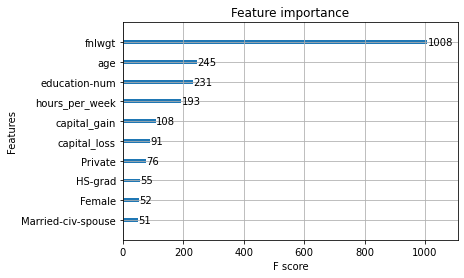

In [8]:
import matplotlib.pyplot as plt
xgb.plot_importance(model, max_num_features=10)
plt.rcParams['figure.figsize'] = [5, 3]
plt.show()

# LightGBM

In [9]:
# method 1: sklearn API
model = lgb.LGBMClassifier()
model.fit(x_train, y_train)
ypred = model.predict(x_test)
#Converting probabilities into 1 or 0  
for i in range(0,len(ypred)): 
    if ypred[i]>=.5:       # setting threshold to .5 
        ypred[i]=1 
    else: 
        ypred[i]=0   

In [10]:
from sklearn.metrics import accuracy_score 
accuracy_lgb = accuracy_score(y_test,ypred) 
accuracy_lgb

0.8614618166928274

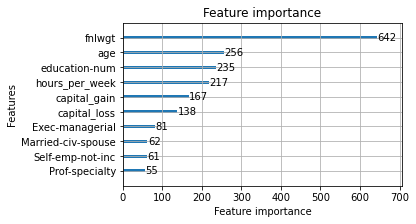

In [11]:
lgb.plot_importance(model, max_num_features=10)
plt.rcParams['figure.figsize'] = [5, 3]
plt.show()

# Sklearn Grid Search for Xgboost

- list of parameters https://xgboost.readthedocs.io/en/latest/parameter.html

In [12]:
from sklearn.model_selection import GridSearchCV


model = xgb.XGBClassifier(use_label_encoder=False, verbosity=0)
parameters = {
     "eta"    : [0.05,  0.20] ,
     "max_depth"        : [ 3, 5 ],
     "min_child_weight" : [ 1, 3],
     "gamma"            : [ 0.0, 0.1],
     "colsample_bytree" : [ 0.3, 0.5]
     }

grid = GridSearchCV(model, parameters, n_jobs=-1, cv=3)

grid.fit(x_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [13]:
print(grid.best_params_)
print(grid.best_score_)

{'colsample_bytree': 0.5, 'eta': 0.2, 'gamma': 0.0, 'max_depth': 3, 'min_child_weight': 3}
0.8577027807746417


# Sklearn Grid Search for LightGBM

- list of parameters https://lightgbm.readthedocs.io/en/latest/Parameters.html
- guidance on parameter tuning https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

In [14]:
%%capture
from sklearn.model_selection import GridSearchCV

model = lgb.LGBMClassifier()
parameters = {
    'num_leaves':[100,150], 
    'max_depth':[5,7],
    'learning_rate':[.01,.05],
    'max_bin':[100,200]  
     }

grid = GridSearchCV(model, parameters, n_jobs=-1,cv=3)

grid.fit(x_train, y_train)

In [15]:
print(grid.best_params_)
print(grid.best_score_)

{'learning_rate': 0.05, 'max_bin': 200, 'max_depth': 7, 'num_leaves': 100}
0.8551288269635203


# Speed up using DMatrix for Xgboost

In [16]:
#The data is stored in a DMatrix object 
#label is used to define our outcome variable
dtrain=xgb.DMatrix(x_train,label=y_train)
dtest=xgb.DMatrix(x_test)

In [17]:
#setting parameters for xgboost
parameters={'max_depth':7, 'eta':1, 'silent':1,'objective':'binary:logistic','eval_metric':'auc','learning_rate':.05}

In [18]:
#training our model 
num_round=50
from datetime import datetime 
start = datetime.now() 
xg=xgb.train(parameters,dtrain,num_round) 
stop = datetime.now()

In [19]:
#Execution time of the model 
execution_time_xgb = stop-start 
execution_time_xgb

datetime.timedelta(seconds=11, microseconds=659831)

In [20]:
#datetime.timedelta( , , ) representation => (days , seconds , microseconds) 
#now predicting our model on test set 
ypred=xg.predict(dtest) 
ypred

array([0.24878033, 0.2643572 , 0.36049965, ..., 0.8869347 , 0.0509403 ,
       0.23135269], dtype=float32)

In [21]:
y_test.dtype

dtype('int64')

In [22]:
#Converting probabilities into 1 or 0  
for i in range(0,len(ypred)): 
    if ypred[i]>=.5:       # setting threshold to .5 
        ypred[i]=1 
    else: 
        ypred[i]=0   

In [23]:
len(ypred)

14653

In [24]:
#calculating accuracy of our model 
from sklearn.metrics import accuracy_score 
accuracy_xgb = accuracy_score(y_test,ypred) 
accuracy_xgb

0.8553197297481744

# Speed up using lgb.Dataset for light GBM

In [25]:
train_data=lgb.Dataset(x_train,label=y_train)

In [26]:
#setting parameters for lightgbm
param = {'num_leaves':150, 'objective':'binary','max_depth':7,'learning_rate':.05,'max_bin':200,'metric':'auc'}
#param['metric'] = ['auc', 'binary_logloss']

In [27]:
%%capture
#training our model using light gbm

num_round=50
start=datetime.now()
lgbm=lgb.train(param,train_data,num_round)
stop=datetime.now()

In [28]:
#Execution time of the model
execution_time_lgbm = stop-start
execution_time_lgbm

datetime.timedelta(microseconds=418125)

In [29]:
#predicting on test set
ypred2=lgbm.predict(x_test)
ypred2[0:5]  # showing first 5 predictions

array([0.22377957, 0.25224334, 0.34625344, 0.02021831, 0.60779602])

In [30]:

#converting probabilities into 0 or 1
for i in range(0,len(ypred)):
    if ypred2[i]>=.5:       # setting threshold to .5
       ypred2[i]=1
    else:  
       ypred2[i]=0

In [31]:
#calculating accuracy
accuracy_lgbm = accuracy_score(ypred2,y_test)
accuracy_lgbm
y_test.value_counts()

0    11181
1     3472
Name: Income, dtype: int64

# Adding ROC score for evaluation
ROC explaination: https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5

In [32]:
from sklearn.metrics import roc_auc_score
# ROC score explaination: https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5

In [33]:
#calculating roc_auc_score for xgboost
auc_xgb =  roc_auc_score(y_test,ypred)
auc_xgb

0.763905937471278

In [34]:
#calculating roc_auc_score for light gbm. 
auc_lgbm = roc_auc_score(y_test,ypred2)
comparison_dict = {'accuracy score':(accuracy_lgbm,accuracy_xgb),
                            'auc score':(auc_lgbm,auc_xgb),
                            'execution time':(execution_time_lgbm,execution_time_xgb)}

In [35]:
#Creating a dataframe ‘comparison_df’ for comparing the performance of Lightgbm and xgb. 
comparison_df = DataFrame(comparison_dict) 
comparison_df.index= ['LightGBM','xgboost'] 
comparison_df

,accuracy score,auc score,execution time
LightGBM,0.855934,0.759344,0 days 00:00:00.418125
xgboost,0.855320,0.763906,0 days 00:00:11.659831


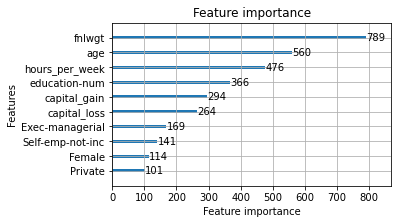

In [36]:
import matplotlib.pyplot as plt
lgb.plot_importance(lgbm, max_num_features=10)
plt.rcParams['figure.figsize'] = [5, 2]
plt.show()

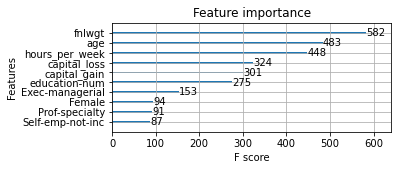

In [37]:

xgb.plot_importance(xg, max_num_features=10)
plt.rcParams['figure.figsize'] = [5, 3]
plt.show()